In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/anna/Desktop/MSU/научка/git/time_series/Forecasting.py'>

In [3]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [63]:
K = 10
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [25]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error as mae
mase = MeanAbsoluteScaledError(multioutput='raw_values')
mase_uni = MeanAbsoluteScaledError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='raw_values')
# mae = MeanAbsoluteError()


#if ‘raw_values’, returns a full set of errors in case of multioutput input. If ‘uniform_average’, errors of all outputs are averaged with uniform weight.

In [6]:
window_sizes_for_clustering = [1, 2, 3, 10]
Ns_clusters = [2, 5, 7, 9, 11]

In [76]:
Ns_clusters = [9]
window_sizes_for_clustering = [3]

In [74]:
dataset = df_np[:100000, ...]
dataset = np.concatenate((dataset[:, :8], dataset[:, 9:]), axis=1)
dataset.shape

(100000, 66)

In [71]:
from collections import defaultdict


clusters_labels.shape=(99999,)
N_clusters=2, 2, 14, (15304, 66)
Before prediction: train_X.shape=(9176, 10, 66), train_y.shape=(9176, 66), test_X.shape=(3059, 10, 66), test_y.shape=(3059, 66)
96/96 [==============================] - 1s 11ms/step
predicted_original.shape=(3059, 66), test_y.shape=(3059, 66)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


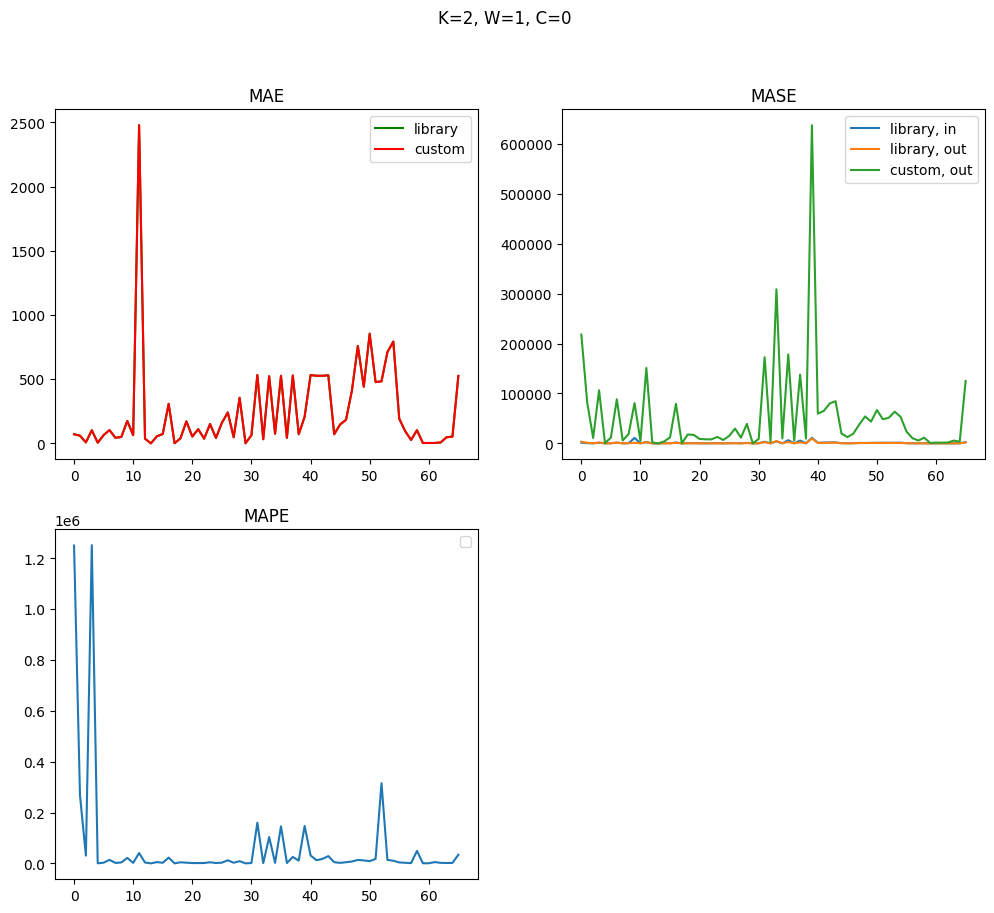

MASE in_sample = [1.36012933e+03 4.56128945e+02 9.04121156e+01 1.29331480e+03
 7.22632535e+00 2.27741813e+02 1.63205695e+03 7.05456272e+01
 3.37170468e+02 1.09105583e+04 1.02417289e+02 2.39866226e+03
 4.30245082e+01 0.00000000e+00 3.83474338e+02 1.70560214e+02
 1.69025717e+03 3.19240843e+00 2.96424158e+02 3.08560414e+02
 1.92837352e+02 1.64264876e+02 1.69071405e+02 2.34223525e+02
 8.91479813e+01 2.85336446e+02 3.57602055e+02 1.31614902e+02
 1.01191807e+03 2.42605522e+00 1.57337988e+02 3.29498119e+03
 6.84400316e+01 4.06657876e+03 1.77851435e+02 6.27125777e+03
 1.07222310e+02 5.64450901e+03 1.13420961e+02 1.11025435e+04
 1.13621244e+03 1.54610989e+03 1.78463700e+03 1.96081024e+03
 3.67083659e+02 1.70347173e+02 2.57147712e+02 9.42118221e+02
 6.88691217e+02 1.05099132e+03 1.09429583e+03 1.19383855e+03
 1.28209925e+03 1.13794434e+03 1.36968884e+03 2.77364482e+02
 1.41531126e+02 9.75838264e+01 2.55456053e+02 2.22379880e+01
 1.59873495e+01 5.26646344e+01 5.52894138e+01 1.30056824e+02
 1.0394

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

<Figure size 640x480 with 0 Axes>

In [75]:
maes = defaultdict(lambda: [])
mases = defaultdict(lambda: [])
mapes = defaultdict(lambda: [])
answers = {}

for window_size in window_sizes_for_clustering:
    for N_clusters in Ns_clusters:
        dataset_windows, dataset_y = Forecasting.create_windows(dataset, window_size=window_size)
        clusters_labels = Clustering.KMeans_for_windows(dataset_windows, W=window_size, N_clusters=N_clusters, max_iter=50)
        print(f"{clusters_labels.shape=}")
        datasets_clusters = Clustering.flatten_from_interceting_windows(dataset_windows, clusters_labels, W=window_size, \
                N_clusters=N_clusters)
        # list of list of ndarrays [N_i, Q], dataset_clusters[cluster_num][i] - i-th part of dataset for cluster_num

        print(f"{N_clusters=}, {len(datasets_clusters)}, {len(datasets_clusters[0])}, {datasets_clusters[0][0].shape}")
        ###window_size for model
        errors = [1] * N_clusters
        for cluster_num in range(N_clusters):
            sc = Forecasting.MyStandardScaler()
            #datasets_clusters[cluster_num] - list of [N_i, Q] ndarrays
            sc.fit(datasets_clusters[cluster_num])
            prepared_data = sc.transform(datasets_clusters[cluster_num])
            data_X, data_y = Forecasting.create_windows(prepared_data, window_size=10)
            #data_X - list of [N_i-W, W, Q] ndarrays
            train_X, train_y, valid_X, valid_y, test_X, test_y, ind = Forecasting.split_to_train_test(data_X, data_y, part_of_test=0.2, part_of_valid=0.2)
            #ndarrays [N_i, W, Q] or [N_i, Q]
            ind = np.array(ind) + window_size
            print(f"Before prediction: {train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
            try:
                assert(predicted_original.shape == test_y.shape)
                assert(len(test_X.shape) == 3 and test_X.shape[0] > 0)
                assert(len(valid_X.shape) == 3 and valid_X.shape[0] > 0)
                assert(len(train_X.shape) == 3 and train_X.shape[0] > 0)
            except AssertionError:
                print(f"FAIL - {test_X.shape=}, {valid_X.shape=}, {train_X.shape=}")
                errors[cluster_num] = np.Inf
                continue
            model, history = Forecasting.learn(train_X, train_y, valid_X=valid_X, valid_y=valid_y)
            predicted = model.predict(test_X)
            predicted_original = sc.inverse_transform(predicted)[0]
            #inverse_trasform returns list of ndarrays 
            predicted_original = sc.add_first_element(predicted_original, ind)[0]
            print(f"{predicted_original.shape=}, {test_y.shape=}")

            cur_mae = mae(test_y, predicted_original, multioutput='raw_values')
            error_out = mase(test_y, predicted_original, y_train=test_y)
            error_in = mase(test_y, predicted_original, y_train=train_y)
            # cur_mase = mase(test_y, predicted_original, y_train=test_y)
            cur_mape = mape(test_y, predicted_original)
            maes[(window_size, N_clusters)].append(cur_mae)
            mases[(window_size, N_clusters)].append((error_in, error_out))
            mapes[(window_size, N_clusters)].append(cur_mape)
            errors[cluster_num] = mase_uni(test_y, predicted_original, y_train=test_y)

            plt.figure(figsize=(12, 10))
            plt.suptitle(f"K={N_clusters}, W={window_size}, C={cluster_num}")
            plt.subplot(2, 2, 1)
            plt.plot(cur_mae, color="green", label="library")
            plt.plot(Forecasting.my_mae(test_y, predicted_original, multioutput='raw_values'), color="red", label="custom")
            plt.title("MAE")
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(error_in, label="library, in")
            plt.plot(error_out, label="library, out")
            plt.plot(Forecasting.my_mase(test_y, predicted_original, multioutput='raw_values'), label="custom, out")
            plt.title("MASE")
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(cur_mape)
            plt.title("MAPE")
            plt.legend()

            # plt.savefig(f"plots/Dataset2/K={N_clusters}  W={window_size} C={cluster_num}.png")
            plt.show()
            plt.clf()
            # print(f"{cur_mae=}, {cur_mase=}, {cur_mape=}")
            # my_mase = mase()
            print(f"MASE in_sample = {error_in}, MASE out_sample = {error_out}")
            print(f"average MASE = {errors[cluster_num]}, my average MASE = {Forecasting.my_mase(test_y, predicted_original, multioutput='uniform_average')}")
            print(f"Cluster {cluster_num}, {errors[cluster_num]}")
        answers[(window_size, N_clusters)] = errors

        plt.figure(figsize=(12, 10))
        plt.suptitle(f"K={N_clusters}, W={window_size}")
        plt.subplot(2, 2, 1)
        plt.bar(np.arange(N_clusters), [np.sum(clusters_labels == i) for i in range(N_clusters)], color='blue')
        plt.title("Размеры кластеров")
        plt.subplot(2, 2, 2)
        plt.bar(np.arange(N_clusters), [len(datasets_clusters[i]) for i in range(N_clusters)], color="green")
        plt.title("Количество непрерывных отрезков")
        plt.subplot(2, 2, 3)
        plt.bar(np.arange(N_clusters), errors, color="red")
        plt.title("MASE на тесте каждого из кластеров")
        plt.subplot(2, 2, 4)
        plt.table(cellText= [[f"{x:.2f}" for x in errors]],
                      rowLabels=["MASE"],
                      colLabels=list(range(N_clusters)),
                      loc='center')
        # plt.show()
        # plt.savefig(f"plots/Dataset2/method1: {N_clusters=}  W={window_size}.png")
        plt.show()
        plt.clf()
        

In [77]:
np.argmax(mases[(1,2)][0]), np.argmax(mases[(1,2)][1]) 

IndexError: list index out of range

In [52]:
for key, val in maes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 10)}")

(1, 2)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4,  8,  9, 10, 11, 12, 14, 15, 16, 18, 19, 21, 25, 28, 30, 31,
       33, 35, 37, 60, 61, 62, 63]),)


In [54]:
for key, val in mases.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c[0] < 1)}, {np.where(val_c[1] < 1)}")

(1, 2)
     (array([14]),), (array([14]),)
     (array([ 9, 14]),), (array([ 9, 12, 14]),)


In [55]:
for key, val in mapes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 1)}")

(1, 2)
     (array([14]),)
     (array([14]),)


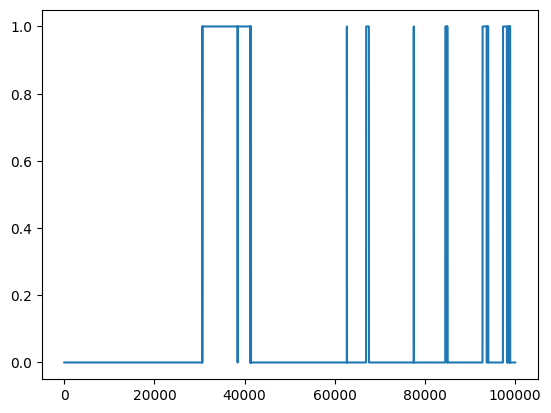

In [53]:
plt.plot(clusters_labels)